We are writing this notebook as first scratch of smoothing stuff to do double cropping classification.

This notebook will eventually be running on Colab. And hopefully we can maitain a .py script in sublime editor.

# import libraries

In [352]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
from IPython.display import Image
from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

## Define Functions

In [546]:
def initial_clean(dt):
    # remove the useles system:index column
    if ("system:index" in list(grant_2018.columns)):
        dt = dt.drop(columns=['system:index'])
    
    # Drop rows whith NA in NDVI column.
    dt = dt[dt['NDVI'].notna()]
    
    # rename the column .geo to "geo"
    dt = dt.rename(columns={".geo": "geo"})
    return (dt)

def short_polygon_ID(dt):
    return (dt)

def order_by_doy(dt):
    return dt.sort_values(by='doy', axis=0, ascending=True)


def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """
    Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    
    y_array = np.array(y)
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y_array[0] - np.abs( y_array[1:half_window+1][::-1] - y_array[0] )
    lastvals = y_array[-1] + np.abs(y_array[-half_window-1:-1][::-1] - y_array[-1])
    y_array = np.concatenate((firstvals, y_array, lastvals))
    return np.convolve( m[::-1], y_array, mode='valid')


def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise (ValueError, 
                'Input vectors y_axis and x_axis must have same length')
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis

def peakdetect(y_axis, x_axis = None, lookahead = 300, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    https://github.com/mattijn/pynotebook/blob/16fe0f58624938b82d93cbd208b8cb871ab95ec1/
    ipynotebooks/Python2.7/.ipynb_checkpoints/PLOTS%20SIGNAL%20PROCESSING-P1%20and%20P2-checkpoint.ipynb
     
    also look at: https://gist.github.com/endolith/250860
    and 
    http://billauer.co.il/peakdet.html
    
    
    
    function for detecting local maximas and minmias in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maximas and minimas respectively
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- (optional) A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the postion of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    lookahead -- (optional) distance to look ahead from a peak candidate to
        determine if it is the actual peak (default: 200) 
        '(sample / period) / f' where '4 >= f >= 1.25' might be a good value
    delta -- (optional) this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            delta function causes a 20% decrease in speed, when omitted
            Correctly used it can double the speed of the function
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError ( "Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError ( "delta must be a positive number" )
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        # no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]

def form_xs_ys_from_peakdetect(max_peak_list, doy_vect):
    dd = np.array(doy_vect)
    xs = np.zeros(len(max_peak_list))
    ys = np.zeros(len(max_peak_list))
    for ii in range(len(max_peak_list)):  
        xs[ii] = dd[int(max_peak_list[ii][0])]
        ys[ii] = max_peak_list[ii][1]
    return (xs, ys)

# Extensive peak detect

In [558]:
#!/usr/bin/python2


# Copyright (C) 2016 Sixten Bergman
# License WTFPL
#
# This program is free software. It comes without any warranty, to the extent
# permitted by applicable law. 
# You can redistribute it and/or modify it under the terms of the Do What The
# Fuck You Want To Public License, Version 2, as published by Sam Hocevar. See
# http://www.wtfpl.net/ for more details.
#
# note that the function peakdetect is derived from code which was released to
# public domain see: http://billauer.co.il/peakdet.html
#

import logging
from math import pi, log
import numpy as np
import pylab
from scipy import fft, ifft
from scipy.optimize import curve_fit
from scipy.signal import cspline1d_eval, cspline1d

__all__ = [
        "peakdetect",
        "peakdetect_fft",
        "peakdetect_parabola",
        "peakdetect_sine",
        "peakdetect_sine_locked",
        "peakdetect_spline",
        "peakdetect_zero_crossing",
        "zero_crossings",
        "zero_crossings_sine_fit"
        ]



def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError( 
                "Input vectors y_axis and x_axis must have same length")
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis
    

def _pad(fft_data, pad_len):
    """
    Pads fft data to interpolate in time domain
    
    keyword arguments:
    fft_data -- the fft
    pad_len --  By how many times the time resolution should be increased by
    
    return: padded list
    """
    l = len(fft_data)
    n = _n(l * pad_len)
    fft_data = list(fft_data)
    
    return fft_data[:l // 2] + [0] * (2**n-l) + fft_data[l // 2:]
    
def _n(x):
    """
    Find the smallest value for n, which fulfils 2**n >= x
    
    keyword arguments:
    x -- the value, which 2**n must surpass
    
    return: the integer n
    """
    return int(log(x)/log(2)) + 1
    
    
def _peakdetect_parabola_fitter(raw_peaks, x_axis, y_axis, points):
    """
    Performs the actual parabola fitting for the peakdetect_parabola function.
        
    keyword arguments:
    raw_peaks -- A list of either the maxima or the minima peaks, as given
        by the peakdetect functions, with index used as x-axis
    
    x_axis -- A numpy array of all the x values
    
    y_axis -- A numpy array of all the y values
    
    points -- How many points around the peak should be used during curve
        fitting, must be odd.
    
    
    return: A list giving all the peaks and the fitted waveform, format:
        [[x, y, [fitted_x, fitted_y]]]
        
    """
    func = lambda x, a, tau, c: a * ((x - tau) ** 2) + c
    fitted_peaks = []
    distance = abs(x_axis[raw_peaks[1][0]] - x_axis[raw_peaks[0][0]]) / 4
    for peak in raw_peaks:
        index = peak[0]
        x_data = x_axis[index - points // 2: index + points // 2 + 1]
        y_data = y_axis[index - points // 2: index + points // 2 + 1]
        # get a first approximation of tau (peak position in time)
        tau = x_axis[index]
        # get a first approximation of peak amplitude
        c = peak[1]
        a = np.sign(c) * (-1) * (np.sqrt(abs(c))/distance)**2
        """Derived from ABC formula to result in a solution where A=(rot(c)/t)**2"""
        
        # build list of approximations
        
        p0 = (a, tau, c)
        popt, pcov = curve_fit(func, x_data, y_data, p0)
        # retrieve tau and c i.e x and y value of peak
        x, y = popt[1:3]
        
        # create a high resolution data set for the fitted waveform
        x2 = np.linspace(x_data[0], x_data[-1], points * 10)
        y2 = func(x2, *popt)
        
        fitted_peaks.append([x, y, [x2, y2]])
        
    return fitted_peaks
    
    
def peakdetect_parabole(*args, **kwargs):
    """
    Misspelling of peakdetect_parabola
    function is deprecated please use peakdetect_parabola
    """
    logging.warn("peakdetect_parabole is deprecated due to misspelling use: peakdetect_parabola")
    
    return peakdetect_parabola(*args, **kwargs)
    
    
def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maxima and minima in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maxima and minima respectively
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks. If omitted an
        index of the y_axis is used.
        (default: None)
    
    lookahead -- distance to look ahead from a peak candidate to determine if
        it is the actual peak
        (default: 200) 
        '(samples / period) / f' where '4 >= f >= 1.25' might be a good value
    
    delta -- this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            When omitted delta function causes a 20% decrease in speed.
            When used Correctly it can double the speed of the function
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]
    
    
def peakdetect_fft(y_axis, x_axis, pad_len = 20):
    """
    Performs a FFT calculation on the data and zero-pads the results to
    increase the time domain resolution after performing the inverse fft and
    send the data to the 'peakdetect' function for peak 
    detection.
    
    Omitting the x_axis is forbidden as it would make the resulting x_axis
    value silly if it was returned as the index 50.234 or similar.
    
    Will find at least 1 less peak then the 'peakdetect_zero_crossing'
    function, but should result in a more precise value of the peak as
    resolution has been increased. Some peaks are lost in an attempt to
    minimize spectral leakage by calculating the fft between two zero
    crossings for n amount of signal periods.
    
    The biggest time eater in this function is the ifft and thereafter it's
    the 'peakdetect' function which takes only half the time of the ifft.
    Speed improvements could include to check if 2**n points could be used for
    fft and ifft or change the 'peakdetect' to the 'peakdetect_zero_crossing',
    which is maybe 10 times faster than 'peakdetct'. The pro of 'peakdetect'
    is that it results in one less lost peak. It should also be noted that the
    time used by the ifft function can change greatly depending on the input.
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks.
    
    pad_len -- By how many times the time resolution should be
        increased by, e.g. 1 doubles the resolution. The amount is rounded up
        to the nearest 2**n amount
        (default: 20)
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    zero_indices = zero_crossings(y_axis, window_len = 11)
    #select a n amount of periods
    last_indice = - 1 - (1 - len(zero_indices) & 1)
    ###
    # Calculate the fft between the first and last zero crossing
    # this method could be ignored if the beginning and the end of the signal
    # are unnecessary as any errors induced from not using whole periods
    # should mainly manifest in the beginning and the end of the signal, but
    # not in the rest of the signal
    # this is also unnecessary if the given data is an amount of whole periods
    ###
    fft_data = fft(y_axis[zero_indices[0]:zero_indices[last_indice]])
    padd = lambda x, c: x[:len(x) // 2] + [0] * c + x[len(x) // 2:]
    n = lambda x: int(log(x)/log(2)) + 1
    # pads to 2**n amount of samples
    fft_padded = padd(list(fft_data), 2 ** 
                n(len(fft_data) * pad_len) - len(fft_data))
    
    # There is amplitude decrease directly proportional to the sample increase
    sf = len(fft_padded) / float(len(fft_data))
    # There might be a leakage giving the result an imaginary component
    # Return only the real component
    y_axis_ifft = ifft(fft_padded).real * sf #(pad_len + 1)
    x_axis_ifft = np.linspace(
                x_axis[zero_indices[0]], x_axis[zero_indices[last_indice]],
                len(y_axis_ifft))
    # get the peaks to the interpolated waveform
    max_peaks, min_peaks = peakdetect(y_axis_ifft, x_axis_ifft, 500,
                                    delta = abs(np.diff(y_axis).max() * 2))
    #max_peaks, min_peaks = peakdetect_zero_crossing(y_axis_ifft, x_axis_ifft)
    
    # store one 20th of a period as waveform data
    data_len = int(np.diff(zero_indices).mean()) / 10
    data_len += 1 - data_len & 1
    
    
    return [max_peaks, min_peaks]
    
    
def peakdetect_parabola(y_axis, x_axis, points = 31):
    """
    Function for detecting local maxima and minima in a signal.
    Discovers peaks by fitting the model function: y = k (x - tau) ** 2 + m
    to the peaks. The amount of points used in the fitting is set by the
    points argument.
    
    Omitting the x_axis is forbidden as it would make the resulting x_axis
    value silly, if it was returned as index 50.234 or similar.
    
    will find the same amount of peaks as the 'peakdetect_zero_crossing'
    function, but might result in a more precise value of the peak.
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks.
    
    points -- How many points around the peak should be used during curve
        fitting (default: 31)
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # make the points argument odd
    points += 1 - points % 2
    #points += 1 - int(points) & 1 slower when int conversion needed
    
    # get raw peaks
    max_raw, min_raw = peakdetect_zero_crossing(y_axis)
    
    # define output variable
    max_peaks = []
    min_peaks = []
    
    max_ = _peakdetect_parabola_fitter(max_raw, x_axis, y_axis, points)
    min_ = _peakdetect_parabola_fitter(min_raw, x_axis, y_axis, points)
    
    max_peaks = map(lambda x: [x[0], x[1]], max_)
    max_fitted = map(lambda x: x[-1], max_)
    min_peaks = map(lambda x: [x[0], x[1]], min_)
    min_fitted = map(lambda x: x[-1], min_)
    
    return [max_peaks, min_peaks]
    

def peakdetect_sine(y_axis, x_axis, points = 31, lock_frequency = False):
    """
    Function for detecting local maxima and minima in a signal.
    Discovers peaks by fitting the model function:
    y = A * sin(2 * pi * f * (x - tau)) to the peaks. The amount of points used
    in the fitting is set by the points argument.
    
    Omitting the x_axis is forbidden as it would make the resulting x_axis
    value silly if it was returned as index 50.234 or similar.
    
    will find the same amount of peaks as the 'peakdetect_zero_crossing'
    function, but might result in a more precise value of the peak.
    
    The function might have some problems if the sine wave has a
    non-negligible total angle i.e. a k*x component, as this messes with the
    internal offset calculation of the peaks, might be fixed by fitting a 
    y = k * x + m function to the peaks for offset calculation.
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks.
    
    points -- How many points around the peak should be used during curve
        fitting (default: 31)
    
    lock_frequency -- Specifies if the frequency argument of the model
        function should be locked to the value calculated from the raw peaks
        or if optimization process may tinker with it.
        (default: False)
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # make the points argument odd
    points += 1 - points % 2
    #points += 1 - int(points) & 1 slower when int conversion needed
    
    # get raw peaks
    max_raw, min_raw = peakdetect_zero_crossing(y_axis)
    
    # define output variable
    max_peaks = []
    min_peaks = []
    
    # get global offset
    offset = np.mean([np.mean(max_raw, 0)[1], np.mean(min_raw, 0)[1]])
    # fitting a k * x + m function to the peaks might be better
    #offset_func = lambda x, k, m: k * x + m
    
    # calculate an approximate frequency of the signal
    Hz_h_peak = np.diff(zip(*max_raw)[0]).mean()
    Hz_l_peak = np.diff(zip(*min_raw)[0]).mean()
    Hz = 1 / np.mean([Hz_h_peak, Hz_l_peak])
    
    
    
    # model function
    # if cosine is used then tau could equal the x position of the peak
    # if sine were to be used then tau would be the first zero crossing
    if lock_frequency:
        func = lambda x_ax, A, tau: A * np.sin(
            2 * pi * Hz * (x_ax - tau) + pi / 2)
    else:
        func = lambda x_ax, A, Hz, tau: A * np.sin(
            2 * pi * Hz * (x_ax - tau) + pi / 2)
    #func = lambda x_ax, A, Hz, tau: A * np.cos(2 * pi * Hz * (x_ax - tau))
    
    
    #get peaks
    fitted_peaks = []
    for raw_peaks in [max_raw, min_raw]:
        peak_data = []
        for peak in raw_peaks:
            index = peak[0]
            x_data = x_axis[index - points // 2: index + points // 2 + 1]
            y_data = y_axis[index - points // 2: index + points // 2 + 1]
            # get a first approximation of tau (peak position in time)
            tau = x_axis[index]
            # get a first approximation of peak amplitude
            A = peak[1]
            
            # build list of approximations
            if lock_frequency:
                p0 = (A, tau)
            else:
                p0 = (A, Hz, tau)
            
            # subtract offset from wave-shape
            y_data -= offset
            popt, pcov = curve_fit(func, x_data, y_data, p0)
            # retrieve tau and A i.e x and y value of peak
            x = popt[-1]
            y = popt[0]
            
            # create a high resolution data set for the fitted waveform
            x2 = np.linspace(x_data[0], x_data[-1], points * 10)
            y2 = func(x2, *popt)
            
            # add the offset to the results
            y += offset
            y2 += offset
            y_data += offset
            
            peak_data.append([x, y, [x2, y2]])
       
        fitted_peaks.append(peak_data)
    
    # structure date for output
    max_peaks = map(lambda x: [x[0], x[1]], fitted_peaks[0])
    max_fitted = map(lambda x: x[-1], fitted_peaks[0])
    min_peaks = map(lambda x: [x[0], x[1]], fitted_peaks[1])
    min_fitted = map(lambda x: x[-1], fitted_peaks[1])
    
    
    return [max_peaks, min_peaks]

    
def peakdetect_sine_locked(y_axis, x_axis, points = 31):
    """
    Convenience function for calling the 'peakdetect_sine' function with
    the lock_frequency argument as True.
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks.
    points -- How many points around the peak should be used during curve
        fitting (default: 31)
    
    return: see the function 'peakdetect_sine'
    """
    return peakdetect_sine(y_axis, x_axis, points, True)
    
    
def peakdetect_spline(y_axis, x_axis, pad_len=20):
    """
    Performs a b-spline interpolation on the data to increase resolution and
    send the data to the 'peakdetect_zero_crossing' function for peak 
    detection.
    
    Omitting the x_axis is forbidden as it would make the resulting x_axis
    value silly if it was returned as the index 50.234 or similar.
    
    will find the same amount of peaks as the 'peakdetect_zero_crossing'
    function, but might result in a more precise value of the peak.
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks. 
        x-axis must be equally spaced.
    
    pad_len -- By how many times the time resolution should be increased by,
        e.g. 1 doubles the resolution.
        (default: 20)
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # could perform a check if x_axis is equally spaced
    #if np.std(np.diff(x_axis)) > 1e-15: raise ValueError
    # perform spline interpolations
    dx = x_axis[1] - x_axis[0]
    x_interpolated = np.linspace(x_axis.min(), x_axis.max(), len(x_axis) * (pad_len + 1))
    cj = cspline1d(y_axis)
    y_interpolated = cspline1d_eval(cj, x_interpolated, dx=dx,x0=x_axis[0])
    # get peaks
    max_peaks, min_peaks = peakdetect_zero_crossing(y_interpolated, x_interpolated)
    
    return [max_peaks, min_peaks]
    
def peakdetect_zero_crossing(y_axis, x_axis = None, window = 11):
    """
    Function for detecting local maxima and minima in a signal.
    Discovers peaks by dividing the signal into bins and retrieving the
    maximum and minimum value of each the even and odd bins respectively.
    Division into bins is performed by smoothing the curve and finding the
    zero crossings.
    
    Suitable for repeatable signals, where some noise is tolerated. Executes
    faster than 'peakdetect', although this function will break if the offset
    of the signal is too large. It should also be noted that the first and
    last peak will probably not be found, as this function only can find peaks
    between the first and last zero crossing.
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the position of the peaks. If
        omitted an index of the y_axis is used.
        (default: None)
    
    window -- the dimension of the smoothing window; should be an odd integer
        (default: 11)
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    
    zero_indices = zero_crossings(y_axis, window_len = window)
    period_lengths = np.diff(zero_indices)
            
    bins_y = [y_axis[index:index + diff] for index, diff in 
        zip(zero_indices, period_lengths)]
    bins_x = [x_axis[index:index + diff] for index, diff in 
        zip(zero_indices, period_lengths)]
        
    even_bins_y = bins_y[::2]
    odd_bins_y = bins_y[1::2]
    even_bins_x = bins_x[::2]
    odd_bins_x = bins_x[1::2]
    hi_peaks_x = []
    lo_peaks_x = []
    
    #check if even bin contains maxima
    if abs(even_bins_y[0].max()) > abs(even_bins_y[0].min()):
        hi_peaks = [bin.max() for bin in even_bins_y]
        lo_peaks = [bin.min() for bin in odd_bins_y]
        # get x values for peak
        for bin_x, bin_y, peak in zip(even_bins_x, even_bins_y, hi_peaks):
            hi_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
        for bin_x, bin_y, peak in zip(odd_bins_x, odd_bins_y, lo_peaks):
            lo_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
    else:
        hi_peaks = [bin.max() for bin in odd_bins_y]
        lo_peaks = [bin.min() for bin in even_bins_y]
        # get x values for peak
        for bin_x, bin_y, peak in zip(odd_bins_x, odd_bins_y, hi_peaks):
            hi_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
        for bin_x, bin_y, peak in zip(even_bins_x, even_bins_y, lo_peaks):
            lo_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
    
    max_peaks = [[x, y] for x,y in zip(hi_peaks_x, hi_peaks)]
    min_peaks = [[x, y] for x,y in zip(lo_peaks_x, lo_peaks)]
    
    return [max_peaks, min_peaks]
        
    
def _smooth(x, window_len=11, window="hanning"):
    """
    smooth the data using a window of the requested size.
    
    This method is based on the convolution of a scaled window on the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the beginning and end part of the output signal.
    
    keyword arguments:
    x -- the input signal 
    
    window_len -- the dimension of the smoothing window; should be an odd
        integer (default: 11)
    
    window -- the type of window from 'flat', 'hanning', 'hamming', 
        'bartlett', 'blackman', where flat is a moving average
        (default: 'hanning')

    
    return: the smoothed signal
        
    example:

    t = linspace(-2,2,0.1)
    x = sin(t)+randn(len(t))*0.1
    y = _smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, 
    numpy.convolve, scipy.signal.lfilter 
    """
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    
    if window_len<3:
        return x
    #declare valid windows in a dictionary
    window_funcs = {
        "flat": lambda _len: np.ones(_len, "d"),
        "hanning": np.hanning,
        "hamming": np.hamming,
        "bartlett": np.bartlett,
        "blackman": np.blackman
        }
    
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    try:
        w = window_funcs[window](window_len)
    except KeyError:
        raise ValueError(
            "Window is not one of '{0}', '{1}', '{2}', '{3}', '{4}'".format(
            *window_funcs.keys()))
    
    y = np.convolve(w / w.sum(), s, mode = "valid")
    
    return y
    
    
def zero_crossings(y_axis, window_len = 11, 
    window_f="hanning", offset_corrected=False):
    """
    Algorithm to find zero crossings. Smooths the curve and finds the
    zero-crossings by looking for a sign change.
    
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find zero-crossings
    
    window_len -- the dimension of the smoothing window; should be an odd
        integer (default: 11)
    
    window_f -- the type of window from 'flat', 'hanning', 'hamming', 
        'bartlett', 'blackman' (default: 'hanning')
    
    offset_corrected -- Used for recursive calling to remove offset when needed
    
    
    return: the index for each zero-crossing
    """
    # smooth the curve
    length = len(y_axis)
    
    # discard tail of smoothed signal
    y_axis = _smooth(y_axis, window_len, window_f)[:length]
    indices = np.where(np.diff(np.sign(y_axis)))[0]
    
    # check if zero-crossings are valid
    diff = np.diff(indices)
    if diff.std() / diff.mean() > 0.1:
        #Possibly bad zero crossing, see if it's offsets
        if ((diff[::2].std() / diff[::2].mean()) < 0.1 and 
        (diff[1::2].std() / diff[1::2].mean()) < 0.1 and
        not offset_corrected):
            #offset present attempt to correct by subtracting the average
            offset = np.mean([y_axis.max(), y_axis.min()])
            return zero_crossings(y_axis-offset, window_len, window_f, True)
        #Invalid zero crossings and the offset has been removed
        print(diff.std() / diff.mean())
        print(np.diff(indices))
        raise ValueError(
            "False zero-crossings found, indicates problem {0!s} or {1!s}".format(
            "with smoothing window", "unhandled problem with offset"))
    # check if any zero crossings were found
    if len(indices) < 1:
        raise ValueError("No zero crossings found")
    #remove offset from indices due to filter function when returning
    return indices - (window_len // 2 - 1)
    # used this to test the fft function's sensitivity to spectral leakage
    #return indices + np.asarray(30 * np.random.randn(len(indices)), int)
    
############################Frequency calculation#############################
#    diff = np.diff(indices)
#    time_p_period = diff.mean()
#    
#    if diff.std() / time_p_period > 0.1:
#        raise ValueError(
#            "smoothing window too small, false zero-crossing found")
#    
#    #return frequency
#    return 1.0 / time_p_period
##############################################################################


def zero_crossings_sine_fit(y_axis, x_axis, fit_window = None, smooth_window = 11):
    """
    Detects the zero crossings of a signal by fitting a sine model function
    around the zero crossings:
    y = A * sin(2 * pi * Hz * (x - tau)) + k * x + m
    Only tau (the zero crossing) is varied during fitting.
    
    Offset and a linear drift of offset is accounted for by fitting a linear
    function the negative respective positive raw peaks of the wave-shape and
    the amplitude is calculated using data from the offset calculation i.e.
    the 'm' constant from the negative peaks is subtracted from the positive
    one to obtain amplitude.
    
    Frequency is calculated using the mean time between raw peaks.
    
    Algorithm seems to be sensitive to first guess e.g. a large smooth_window
    will give an error in the results.
    
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the position of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    
    fit_window -- Number of points around the approximate zero crossing that
        should be used when fitting the sine wave. Must be small enough that
        no other zero crossing will be seen. If set to none then the mean
        distance between zero crossings will be used (default: None)
    
    smooth_window -- the dimension of the smoothing window; should be an odd
        integer (default: 11)
    
    
    return: A list containing the positions of all the zero crossings.
    """
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    #get first guess
    zero_indices = zero_crossings(y_axis, window_len = smooth_window)
    #modify fit_window to show distance per direction
    if fit_window == None:
        fit_window = np.diff(zero_indices).mean() // 3
    else:
        fit_window = fit_window // 2
    
    #x_axis is a np array, use the indices to get a subset with zero crossings
    approx_crossings = x_axis[zero_indices]
    
    
    
    #get raw peaks for calculation of offsets and frequency
    raw_peaks = peakdetect_zero_crossing(y_axis, x_axis)
    #Use mean time between peaks for frequency
    ext = lambda x: list(zip(*x)[0])
    _diff = map(np.diff, map(ext, raw_peaks))
    
    
    Hz = 1 / np.mean(map(np.mean, _diff))
    #Hz = 1 / np.diff(approx_crossings).mean() #probably bad precision
    
    
    #offset model function
    offset_func = lambda x, k, m: k * x + m
    k = []
    m = []
    amplitude = []
    
    for peaks in raw_peaks:
        #get peak data as nparray
        x_data, y_data = map(np.asarray, zip(*peaks))
        #x_data = np.asarray(x_data)
        #y_data = np.asarray(y_data)
        #calc first guess
        A = np.mean(y_data)
        p0 = (0, A)
        popt, pcov = curve_fit(offset_func, x_data, y_data, p0)
        #append results
        k.append(popt[0])
        m.append(popt[1])
        amplitude.append(abs(A))
    
    #store offset constants
    p_offset = (np.mean(k), np.mean(m))
    A = m[0] - m[1]
    #define model function to fit to zero crossing
    #y = A * sin(2*pi * Hz * (x - tau)) + k * x + m
    func = lambda x, tau: A * np.sin(2 * pi * Hz * (x - tau)) + offset_func(x, *p_offset)
    
    
    #get true crossings
    true_crossings = []
    for indice, crossing in zip(zero_indices, approx_crossings):
        p0 = (crossing, )
        subset_start = max(indice - fit_window, 0.0)
        subset_end = min(indice + fit_window + 1, len(x_axis) - 1.0)
        x_subset = np.asarray(x_axis[subset_start:subset_end])
        y_subset = np.asarray(y_axis[subset_start:subset_end])
        #fit
        popt, pcov = curve_fit(func, x_subset, y_subset, p0)
        
        true_crossings.append(popt[0])
    
    
    return true_crossings


## Define directories
Here we can define data or core.py directories

In [3]:
data_dir = "/Users/hn/Documents/01_research_data/Ag_check_point/remote_sensing/01_NDVI_TS/Grant/"

## Define some parameters

In [4]:
file_names = ["Grant_2018_TS.csv"]

## Read Data

In [5]:
file_N = file_names[0]
grant_2018 = pd.read_csv(data_dir + file_N)

In [6]:
print ("The data before cleaning is of size", str(grant_2018.shape))
grant_2018 = initial_clean(grant_2018)
print ("The data after cleaning is of size", str(grant_2018.shape))

The data before cleaning is of size (385, 24)
The data after cleaning is of size (378, 23)


In [7]:
# Count distict values, use nunique:
pprint (grant_2018['geo'].nunique())

# Count only non-null values, use count:
print (grant_2018['geo'].count())

# Count total values including null values, use size attribute:
print (grant_2018['geo'].size)

7
378
378


#### List of unique polygons

In [14]:
polygon_list = grant_2018['geo'].unique()

# Pick one of the polygons and test the smoothing methods

In [185]:
grant_2018_first_field = grant_2018[grant_2018['geo']==polygon_list[1]]
grant_2018_first_field = order_by_doy(grant_2018_first_field)
print(grant_2018_first_field.shape)
print(type(grant_2018_first_field))
grant_2018_first_field.head(2)

(54, 23)
<class 'pandas.core.frame.DataFrame'>


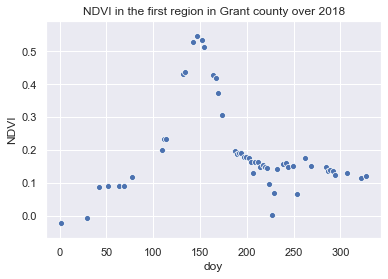

In [561]:
# ax = plt.gca()
# grant_2018_first_field.plot(kind='line',x='doy',y='NDVI',ax=ax)
# plt.show();
sb.set();
plot = sb.scatterplot(x="doy", y="NDVI", data=grant_2018_first_field)
plot = plot.set(title = 'NDVI in the first region in Grant county over 2018');

In [567]:
X = grant_2018_first_field['doy']
y = grant_2018_first_field['NDVI']

### 1.  Weighted Least Square

In [192]:
# print(res_wls.summary())

In [ ]:
def peakdetect_spline(y_axis, x_axis, pad_len=20):
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    dx = x_axis[1] - x_axis[0]
    x_interpolated = np.linspace(x_axis.min(), x_axis.max(), len(x_axis) * (pad_len + 1))
    cj = cspline1d(y_axis)
    y_interpolated = cspline1d_eval(cj, x_interpolated, dx=dx,x0=x_axis[0])
    max_peaks, min_peaks = peakdetect_zero_crossing(y_interpolated, x_interpolated)
    
    return [max_peaks, min_peaks]
    
def peakdetect_zero_crossing(y_axis, x_axis = None, window = 11):
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    
    zero_indices = zero_crossings(y_axis, window_len = window)
    period_lengths = np.diff(zero_indices)
            
    bins_y = [y_axis[index:index + diff] for index, diff in 
        zip(zero_indices, period_lengths)]
    bins_x = [x_axis[index:index + diff] for index, diff in 
        zip(zero_indices, period_lengths)]
        
    even_bins_y = bins_y[::2]
    odd_bins_y = bins_y[1::2]
    even_bins_x = bins_x[::2]
    odd_bins_x = bins_x[1::2]
    hi_peaks_x = []
    lo_peaks_x = []
    
    #check if even bin contains maxima
    if abs(even_bins_y[0].max()) > abs(even_bins_y[0].min()):
        hi_peaks = [bin.max() for bin in even_bins_y]
        lo_peaks = [bin.min() for bin in odd_bins_y]
        # get x values for peak
        for bin_x, bin_y, peak in zip(even_bins_x, even_bins_y, hi_peaks):
            hi_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
        for bin_x, bin_y, peak in zip(odd_bins_x, odd_bins_y, lo_peaks):
            lo_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
    else:
        hi_peaks = [bin.max() for bin in odd_bins_y]
        lo_peaks = [bin.min() for bin in even_bins_y]
        # get x values for peak
        for bin_x, bin_y, peak in zip(odd_bins_x, odd_bins_y, hi_peaks):
            hi_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
        for bin_x, bin_y, peak in zip(even_bins_x, even_bins_y, lo_peaks):
            lo_peaks_x.append(bin_x[np.where(bin_y==peak)[0][0]])
    
    max_peaks = [[x, y] for x,y in zip(hi_peaks_x, hi_peaks)]
    min_peaks = [[x, y] for x,y in zip(lo_peaks_x, lo_peaks)]
    
    return [max_peaks, min_peaks]
        
    

In [573]:
peakdetect_spline(y_axis=y , x_axis=X, pad_len=5)

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning: Mean of empty slice.


IndexError: list index out of range

### Locally weighted regression
   - The [documentation page](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html) from stats model package
   
In the following the parameters are:

   - `frac`:  Between 0 and 1. The fraction of the data used when estimating each y-value.
   - `itint`: The number of residual-based reweightings to perform.

In [574]:
lowess = sm.nonparametric.lowess
LWLS_1 = lowess(endog=y, exog=X, frac= 1./3, it=0)
LWLS_2 = lowess(endog=y, exog=X, frac= 1./3)
LWLS_3 = lowess(endog=y, exog=X, frac= 1./3, it=5)
# predict_3 = lowess(endog=y, exog=X)

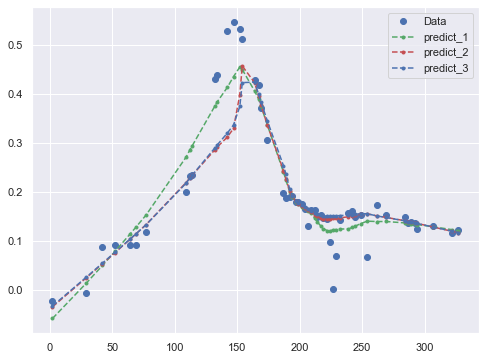

In [575]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(X, y, 'o', label="Data");

ax.plot(X, LWLS_1[:, 1], 'g--.', label="predict_1")
ax.plot(X, LWLS_2[:, 1], 'r--.', label="predict_2")
ax.plot(X, LWLS_3[:, 1], 'b--.', label="predict_3")
ax.legend(loc="best");

## Savitzky Golay filtering

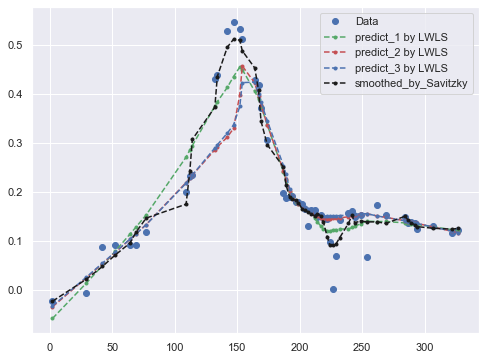

In [576]:
smoothed_by_Savitzky = savitzky_golay(y, window_size=5, order=1)
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(X, y, 'o', label="Data");

ax.plot(X, LWLS_1[:, 1], 'g--.', label="predict_1 by LWLS")
ax.plot(X, LWLS_2[:, 1], 'r--.', label="predict_2 by LWLS")
ax.plot(X, LWLS_3[:, 1], 'b--.', label="predict_3 by LWLS")
ax.plot(X, smoothed_by_Savitzky, 'k--.', label="smoothed_by_Savitzky")
ax.legend(loc="best");

## Gaussian Filtering/convolution 
[Documentation page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)

In [577]:
gaussian_smoothed = scipy.ndimage.gaussian_filter(input=y, sigma=2.5, order=0)

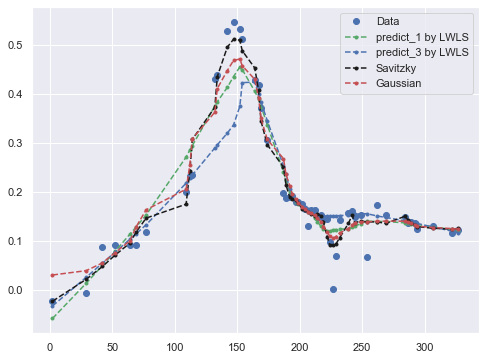

In [578]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(X, y, 'o', label="Data");

ax.plot(X, LWLS_1[:, 1], 'g--.', label="predict_1 by LWLS")
ax.plot(X, LWLS_3[:, 1], 'b--.', label="predict_3 by LWLS")
ax.plot(X, smoothed_by_Savitzky, 'k--.', label="Savitzky")
ax.plot(X, gaussian_smoothed, 'r--.', label="Gaussian")
ax.legend(loc="best");

## Spline Smooothing

In [579]:
freedom_df = 7

# Generate spline basis with 10 degrees of freedom
x_basis = cr(X, df=freedom_df, constraints='center')

# Fit model to the data
model = LinearRegression().fit(x_basis, y)

# Get estimates
y_hat = model.predict(x_basis)


#### Plot smoothing spline result

Text(0.5, 1.0, 'Natural cubic spline with 7 degrees of freedom')

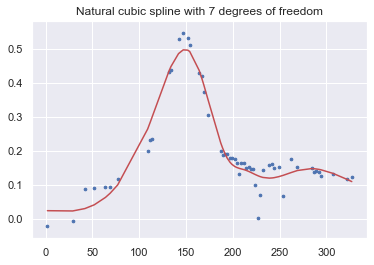

In [580]:
plt.scatter(X, y, s=7)
plt.plot(X, y_hat, 'r', label="smoothing spline result");
plt.title(f'Natural cubic spline with {freedom_df} degrees of freedom')

In [581]:
# find peaks
peaks = peakdetect(LWLS_1[:, 1], lookahead = 10, delta=0)
max_peaks = peaks[0]
peaks = form_xs_ys_from_peakdetect(max_peak_list = max_peaks, doy_vect=X)

### Plot peaks

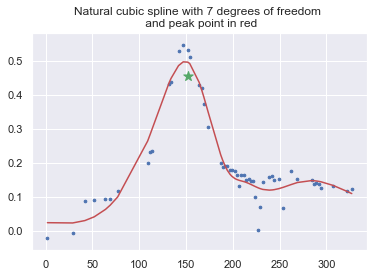

In [627]:
plt.scatter(X, y, s=7);
plt.scatter(peaks[0], peaks[1], s=100, c='g', marker='*');
plt.plot(X, y_hat, 'r');
plt.title(f'Natural cubic spline with {freedom_df} degrees of freedom \n and peak point in red');

In [ ]:
# ax = plt.gca()
# grant_2018_first_field.plot(kind='line',x='doy',y='NDVI',ax=ax)
# plt.show();
sb.set();
plot = sb.scatterplot(x="doy", y="NDVI", data=grant_2018_first_field)
plot = plot.plot(X, y_hat, 'r', label="smoothing spline result");
# plot = plot.set(title = 'NDVI in the first region in Grant county over 2018');

Unweighted fit parameters: [11.8477208   3.58533881  4.31896771]
Covariance matrix:
[[ 0.05982138 -0.00080134  0.00336501]
 [-0.00080134  0.04226655 -0.05701593]
 [ 0.00336501 -0.05701593  0.15097398]]
rms error in fit: 3.6953877284802235

Weighted fit parameters: [12.01461195  3.21216316  4.89417693]
Covariance matrix:
[[ 0.01735012 -0.00325771  0.00610752]
 [-0.00325771  0.01171415 -0.02001634]
 [ 0.00610752 -0.02001634  0.05444542]]
rms error in fit: 1.6301589263032605


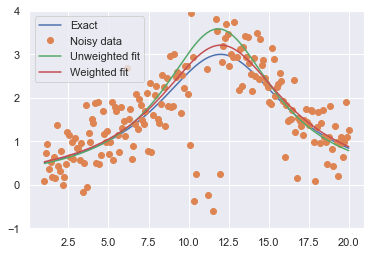

In [162]:
import numpy as np
from scipy.optimize import curve_fit
import pylab

x0, A, gamma = 12, 3, 5

n = 200
x = np.linspace(1, 20, n)
yexact = A * gamma**2 / (gamma**2 + (x-x0)**2)

# Add some noise with a sigma of 0.5 apart from a particularly noisy region
# near x0 where sigma is 3
sigma = np.ones(n)*0.5
sigma[np.abs(x-x0+1)<1] = 3
noise = np.random.randn(n) * sigma
y = yexact + noise

def f(x, x0, A, gamma):
    """ The Lorentzian entered at x0 with amplitude A and HWHM gamma. """
    return A *gamma**2 / (gamma**2 + (x-x0)**2)

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

# Unweighted fit
p0 = 10, 4, 2
popt, pcov = curve_fit(f, x, y, p0)
yfit = f(x, *popt)
print('Unweighted fit parameters:', popt)
print('Covariance matrix:'); print(pcov)
print('rms error in fit:', rms(yexact, yfit))
print()

# Weighted fit
popt2, pcov2 = curve_fit(f, x, y, p0, sigma=sigma, absolute_sigma=True)
yfit2 = f(x, *popt2)
print('Weighted fit parameters:', popt2)
print('Covariance matrix:'); print(pcov2)
print('rms error in fit:', rms(yexact, yfit2))

pylab.plot(x, yexact, label='Exact')
pylab.plot(x, y, 'o', label='Noisy data')
pylab.plot(x, yfit, label='Unweighted fit')
pylab.plot(x, yfit2, label='Weighted fit')
pylab.ylim(-1,4)
pylab.legend(loc='best')
pylab.show()

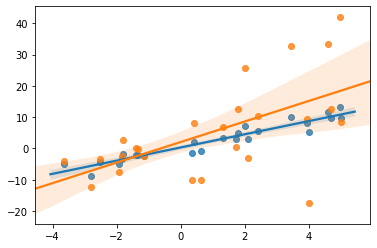

In [12]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
%matplotlib inline
# generate random data
np.random.seed(24)
x = np.random.uniform(-5,5,25)
ϵ = 2*np.random.randn(25)
y = 2*x+ϵ

# alternate error as a function of x
ϵ2 = ϵ*(x+5)
y2 = 2*x+ϵ2
sns.regplot(x,y);
sns.regplot(x,y2);


# add a strong outlier for high x
x_high = np.append(x,5)
y_high = np.append(y2,160)
# add a strong outlier for low x
x_low = np.append(x,-4)
y_low = np.append(y2,160) 

In [17]:
# reshape for compatibility
X_low = x_low.reshape(-1, 1)
X_high = x_high.reshape(-1, 1)

# calculate weights for sets with low and high outlier
sample_weights_low = [1/(x+5) for x in x_low]
sample_weights_high = [1/(x+5) for x in x_high] 

# ---------


# import and fit an OLS model, check coefficients
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_low, y_low)
# fit WLS using sample_weights
WLS = LinearRegression()
WLS.fit(X_low, y_low, sample_weight=sample_weights_low)
print(model.intercept_, model.coef_)
print('WLS')
print(WLS.intercept_, WLS.coef_)
# run this yourself, don't trust every result you see online =)

11.928279162202099 [-0.80996264]
WLS
17.49178858287187 [-7.72446701]


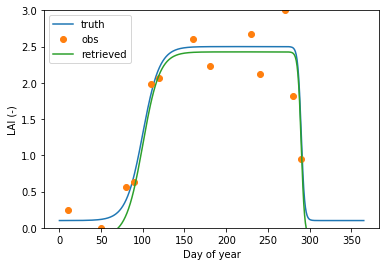

In [28]:
#
# double logistic 
#
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import ad


def double_logistic_array(params,timeArr):
    phenology=[]
    for time in timeArr:
        phenology.append(double_logistic(params,time))
    return np.array(phenology)

def double_logistic(params,time):
    """Generate a double logistic curve similar 
    to those of the MODIS phenology product
    
    k1   --- curvature parmeter for first half of season
    k2   --- curvature parmeter for second half of season
    t01  --- timing parmeter for first half of season
    t02  --- timing parmeter for second half of season
    c    --- minimum LAI/NDVI etc
    d    --- maximum LAI/NDVI etc
    
    time --- time valueto evaluate the function 
    """
    k1  =params[0]
    k2  =params[1]
    t01 =params[2]
    t02 =params[3]
    c   =params[4]
    d   =params[5]
    lgstc1=(c-d)/(1.+math.exp(k1*(time-t01)))+d    
    lgstc2=(d-c)/(1.+math.exp(k2*(time-t02)))+c
    return np.min([lgstc1,lgstc2])
    
def genSynthObs(params,freq=10,stddev=0.3,cloud=0.0):
    
    time_arr=[]
    synth_obs=[]
    for t in range(0,366,freq):
        if np.random.rand()<cloud:
            continue
        time_arr.append(t)
        obs=double_logistic(params,t)
        obs=obs+np.random.normal(0.,stddev)
        synth_obs.append(obs)
        
    return np.array(synth_obs),np.array(time_arr)


def rmse(params,obs,obs_time):
    model=double_logistic_array(params,obs_time)
    return np.sqrt(np.sum((model-obs)**2)/float(len(obs_time)))
    
def solver(params,obs,obs_time,costFunction):
    costGradient, costHessian=ad.gh(costFunction)
    return minimize(costFunction,\
                    params,\
                    args=(obs,obs_time),\
                    method='L-BFGS-B',\
                    jac=costGradient,\
                    options={'gtol': 1e-10})
    
    
    
if __name__=="__main__":

    time_arr=np.arange(366)
    
    params=np.zeros(6)
    params[0]=0.1
    params[1]=0.5
    params[2]=100
    params[3]=290
    params[4]=0.1
    params[5]=2.5
    
    phenology=double_logistic_array(params,time_arr)
    synth_obs, obs_times=genSynthObs(params,freq=10,stddev=0.25,cloud=0.5)
      
    s=solver(params,synth_obs,obs_times,rmse)
  
    retrieval=double_logistic_array(s.x,time_arr)
  
    plt.plot(time_arr,phenology, label="truth")
    plt.plot(obs_times,synth_obs,"o", label="obs")
    plt.plot(time_arr,retrieval, label="retrieved")

    plt.xlabel("Day of year")
    plt.ylabel("LAI (-)")
    plt.ylim([0,3.0])
    plt.legend()
    # plt.show()
    # plt.savefig("phenology_example.png")

In [30]:
params

array([1.0e-01, 5.0e-01, 1.0e+02, 2.9e+02, 1.0e-01, 2.5e+00])